In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from scipy.ndimage.measurements import label
from functools import reduce
import os
import pickle

Read all the training images here.
Since they are .png images, I use cv2.imread to avoid scaling issues.

In [2]:
cars = glob.glob('vehicles/**/*.png')
noncars = glob.glob('non-vehicles/**/*.png')
print(len(cars),"of Car Images;  ", len(noncars),"of non-Car Images.")

8792 of Car Images;   9019 of non-Car Images.


Show some examples of image

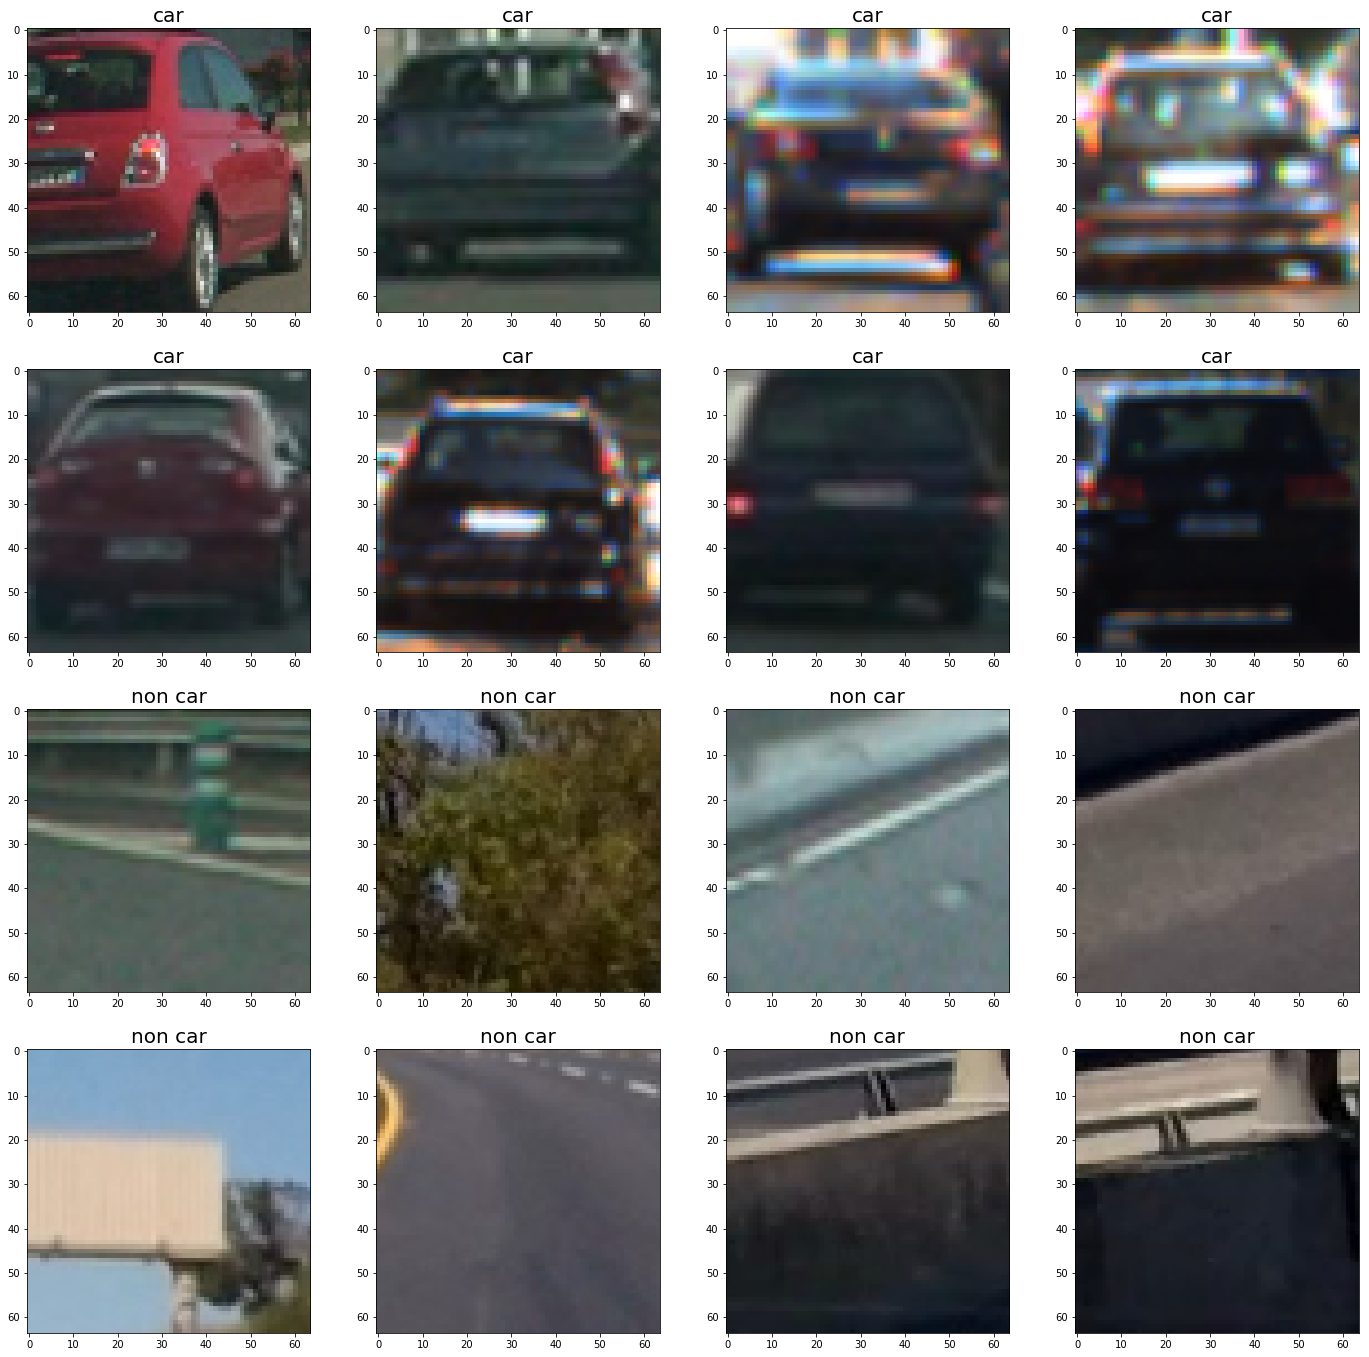

In [3]:
fig, axis = plt.subplots(4,4, figsize=(24, 24))
axis = axis.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(8):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axis[i].set_title('car', fontsize=20)
    axis[i].imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(noncars[np.random.randint(0,len(noncars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axis[i].set_title('non car', fontsize=20)
    axis[i].imshow(img)

## Define function to extract HOG features

In [4]:
# From Class material
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to return HOG features and visualization
# This function will be called in extract_features function
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec,
                                  block_norm="L2-Hys")
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec,
                       block_norm="L2-Hys")
        return features

The following cell is to visualize the results of get_hog_features.

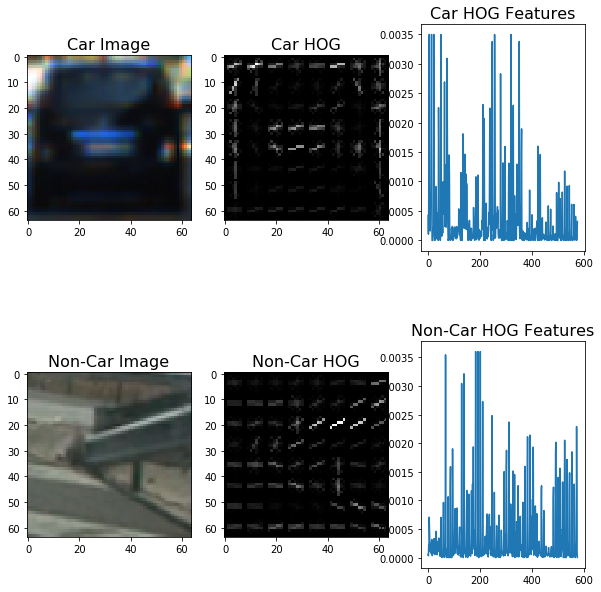

In [6]:
car_img = cv2.imread(cars[np.random.randint(0,len(cars))])
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
car_hog_f, car_hog = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

noncar_img = cv2.imread(noncars[np.random.randint(0,len(noncars))])
noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_BGR2RGB)
noncar_hog_f, noncar_hog = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.plot(car_hog_f)
ax3.set_title('Car HOG Features', fontsize=16)
ax4.imshow(noncar_img)
ax4.set_title('Non-Car Image', fontsize=16)
ax5.imshow(noncar_hog, cmap='gray')
ax5.set_title('Non-Car HOG', fontsize=16)
ax6.plot(noncar_hog_f)
ax6.set_title('Non-Car HOG Features', fontsize=16)

## Extract HOG features of training images, then put them into vectors for training the classifier

In [7]:
# This function is copied from class material
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True,
                        hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat is True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        # Only use HOG features
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

In [8]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

spatial_feat=True
hist_feat=True

t=time.time()

car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_feat=True, hist_feat=True,
                        hog_channel=hog_channel)
noncar_features = extract_features(noncars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_feat=True, hist_feat=True,
                        hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Disabled the normalizing function because I'm only using HOG features.
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Training Feature vector length:', len(X_train[0]))

67.69 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Training Feature vector length: 4356


## Train a linear SVM classifier

In [9]:
# Use a linear SVC 
svc = LinearSVC(C=0.001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:      ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

5.54 Seconds to train SVC...
Test Accuracy of SVC =  0.9933
My SVC predicts:       [ 1.  0.  1.  1.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  0.  0.  1.  0.  0.]
0.002 Seconds to predict 10 labels with SVC


#### The following 3 cells are attemps to use GridSearchCV. Takes 24 minutes to finish training, accuracy is only 1% higher than linear SVC. It also takes 0.024s to predict 10 labels, too slow compared with 0.001s by LinearSCV.

In [ ]:
print(clf.best_params_)

## Run slide window search to locate cars in single images

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rects=False):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog_features.reshape(1,-1)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #X_scaler = StandardScaler().fit(hog_features.reshape(1, -1))
            #hog_features = X_scaler.transform(hog_features.reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rects==True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, rectangles

3


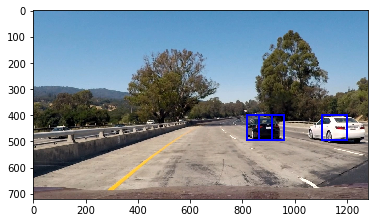

In [11]:
img = mpimg.imread('./test_images/test1.jpg')
    
ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32

out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,spatial_size, hist_bins,show_all_rects=False)

plt.imshow(out_img)
print(len(rects))

## Apply a combination of different sized windows to search for vehicles in all sizes

273


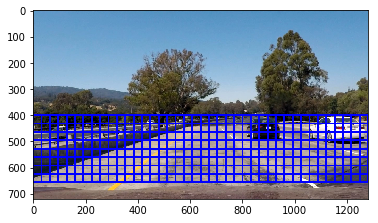

In [12]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

ystart = 400
ystop = 656
scale = 1.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,spatial_size, hist_bins,show_all_rects=True)

plt.imshow(out_img)
print(len(rects))

In [ ]:
### Read the project video and extract images from it, to get more test images

vidcap = cv2.VideoCapture('project_video.mp4')

success,image = vidcap.read()
# image is an array of array of [R,G,B] values
count = 0; 
success = True
while success:
    success,image = vidcap.read()
    if count%50==0:
        cv2.imwrite("test_images"+"\\video_frame%d.jpg" % count, image)     # save frame as JPEG file
    if cv2.waitKey(10) == 27:                     # exit if Escape is hit
        break
    count += 1

78


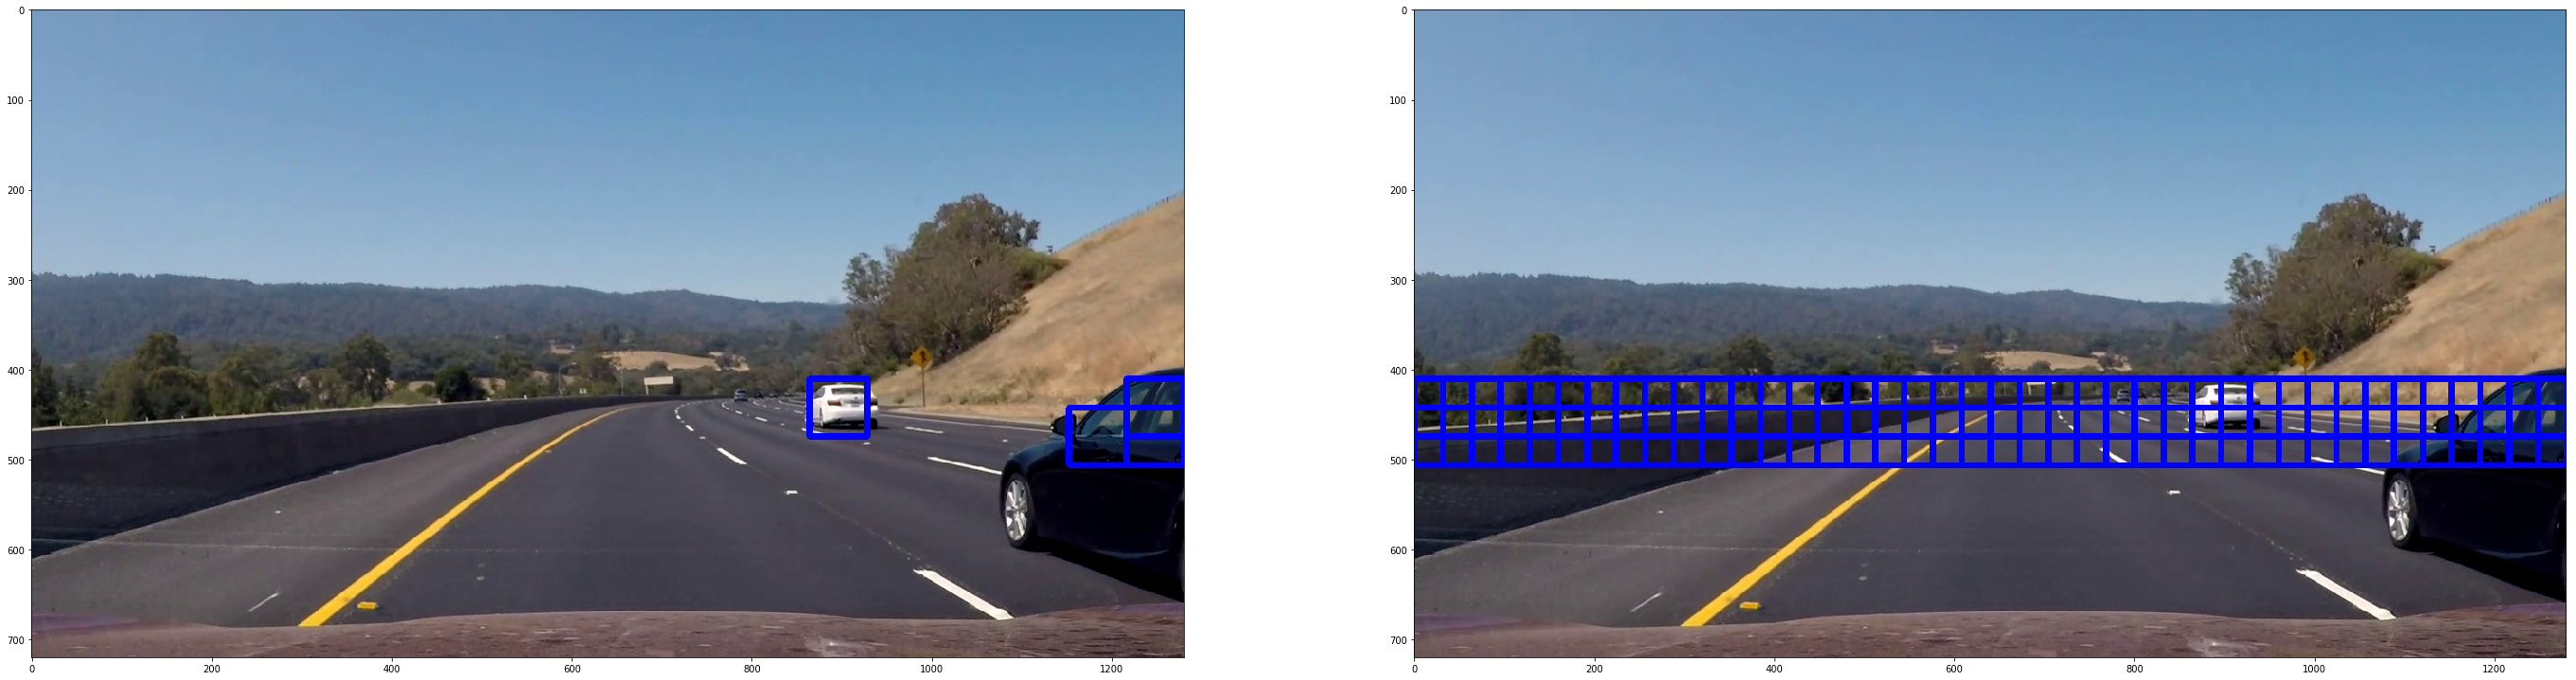

In [13]:
img = mpimg.imread('./test_images/video_frame700.jpg')

ystart = 410
ystop = 510
scale = 1.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
out_web,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=True)

plt.figure(figsize=(48, 24))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(out_web)

print(len(rects))

78


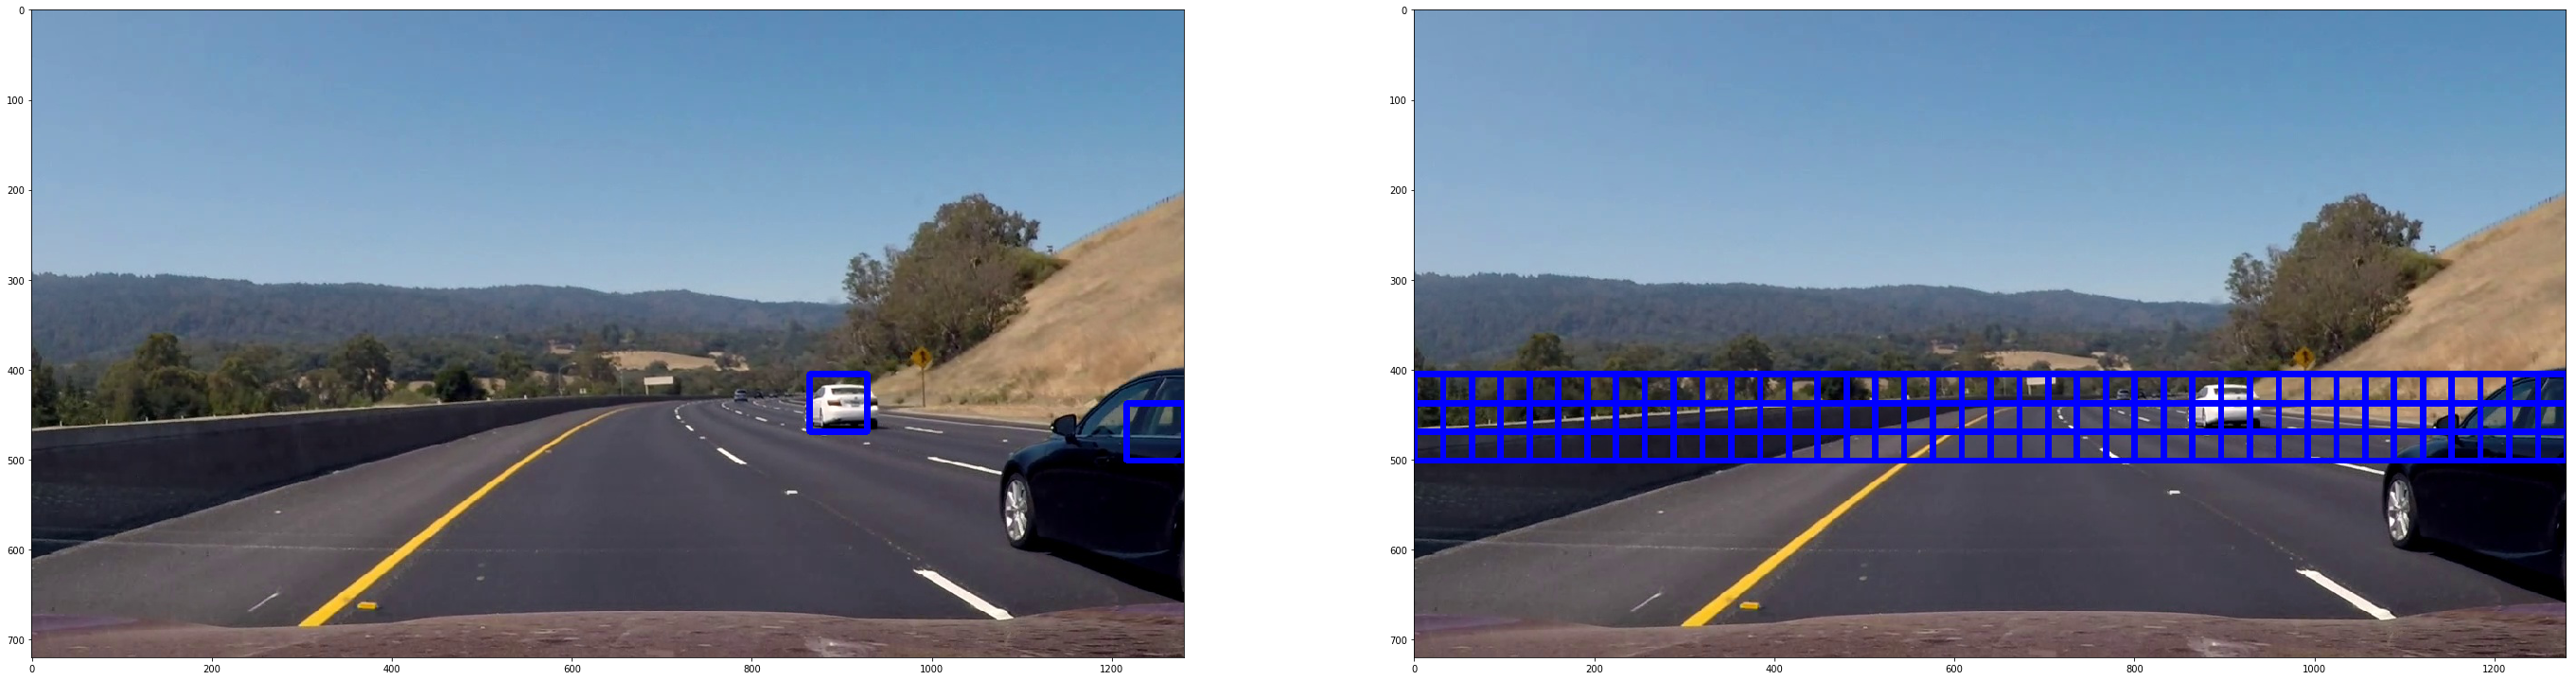

In [14]:
img = mpimg.imread('./test_images/video_frame700.jpg')

ystart = 405
ystop = 510
scale = 1.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
out_web,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=True)

plt.figure(figsize=(48, 24))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(out_web)

print(len(rects))

39


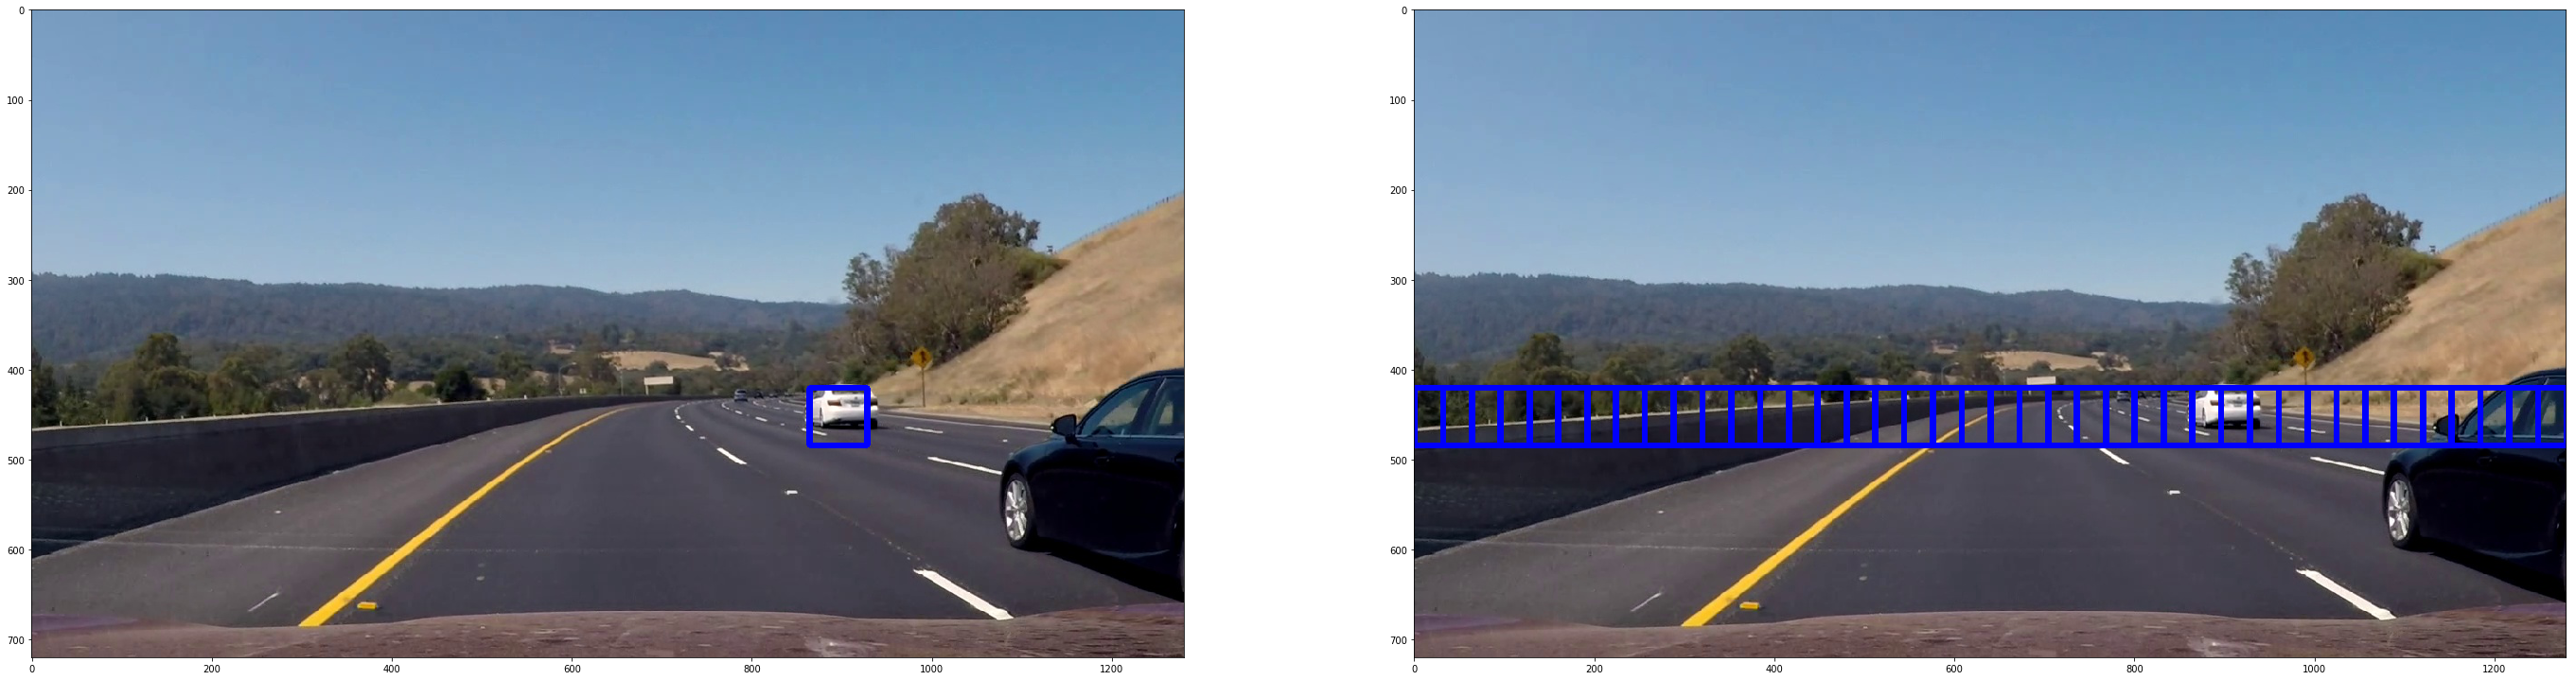

In [15]:
img = mpimg.imread('./test_images/video_frame700.jpg')

ystart = 420
ystop = 484
scale = 1.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
out_web,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=True)

plt.figure(figsize=(48, 24))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(out_web)

print(len(rects))

35


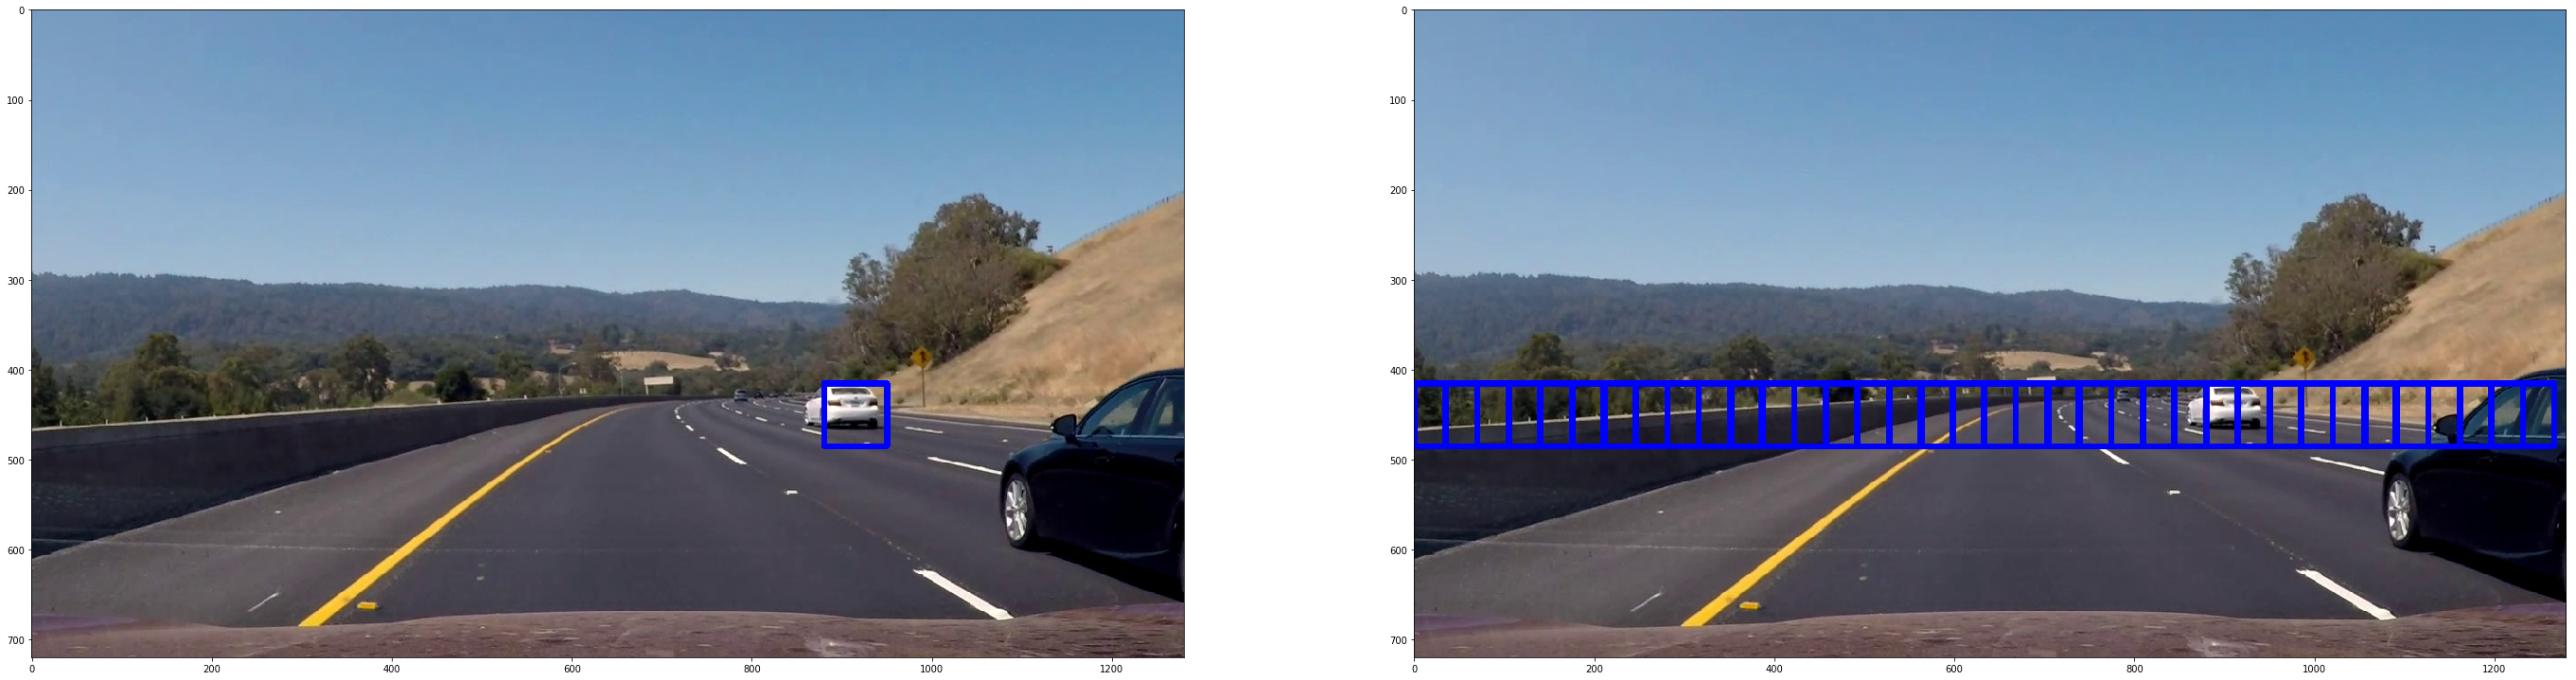

In [16]:
img = mpimg.imread('./test_images/video_frame700.jpg')

ystart = 415
ystop = 500
scale = 1.1
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
out_web,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=True)

plt.figure(figsize=(48, 24))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(out_web)

print(len(rects))

In [ ]:
img = mpimg.imread('./test_images/test5.jpg')

ystart = 420
ystop = 498
scale = 1.2
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
out_web,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=True)

plt.figure(figsize=(48, 24))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(out_web)

print(len(rects))

In [ ]:
img = mpimg.imread('./test_images/test6.jpg')
ystart = 420
ystop = 564
scale = 1.5
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
out_web,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=True)

plt.figure(figsize=(48, 24))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(out_web)

print(len(rects))

In [ ]:
img = mpimg.imread('./test_images/test6.jpg')
ystart = 400
ystop = 628
scale = 2.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
out_web,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=True)

plt.figure(figsize=(48, 24))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(out_web)

print(len(rects))

In [ ]:
img = mpimg.imread('./test_images/video_frame750.jpg')
ystart = 420
ystop = 612
scale = 3.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
out_web,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=True)

plt.figure(figsize=(48, 24))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(out_web)

print(len(rects))

In [ ]:
img = mpimg.imread('./test_images/video_frame750.jpg')
ystart = 410
ystop = 634
scale = 3.5
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
out_web,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=True)

plt.figure(figsize=(48, 24))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(out_web)

print(len(rects))

This piece of code is from class material

In [17]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

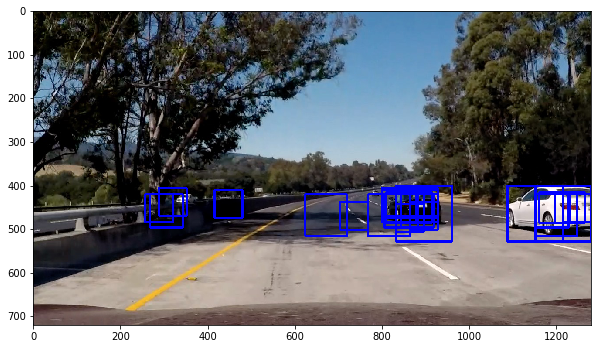

In [24]:
img = mpimg.imread('./test_images/test5.jpg')
rectangles = []

ystart = 405
ystop = 510
scale = 1.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
rectangles.append(rects)

ystart = 410
ystop = 510
scale = 1.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
rectangles.append(rects)

ystart = 420
ystop = 484
scale = 1.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
rectangles.append(rects)

ystart = 415
ystop = 500
scale = 1.1
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
rectangles.append(rects)

ystart = 420
ystop = 498
scale = 1.2
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
rectangles.append(rects)

ystart = 420
ystop = 564
scale = 1.5
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
rectangles.append(rects)

ystart = 400
ystop = 628
scale = 2.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
rectangles.append(rects)

ystart = 420
ystop = 612
scale = 3.0
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
rectangles.append(rects)

ystart = 410
ystop = 634
scale = 3.5
out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
rectangles.append(rects)

rectangles = [item for sublist in rectangles for item in sublist]
img_with_rects = draw_boxes(img, rectangles, color=(0, 0, 255), thick=3)
plt.figure(figsize=(10,10))
plt.imshow(img_with_rects)

## Remove false positives using Heat Map

The following functions are from the class materials

In [25]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

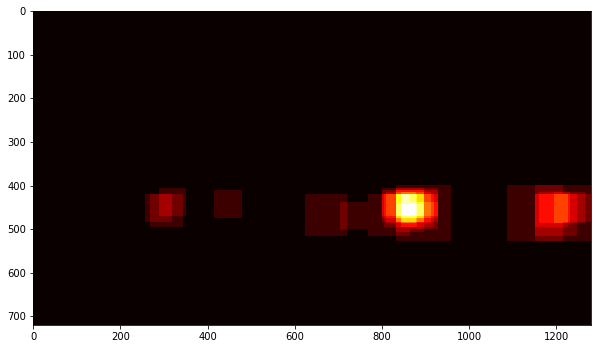

In [26]:
# Read in image similar to one shown above 
image = mpimg.imread('./test_images/test5.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,rectangles)
    
plt.figure(figsize=(10,10))
plt.imshow(heat, cmap='hot')

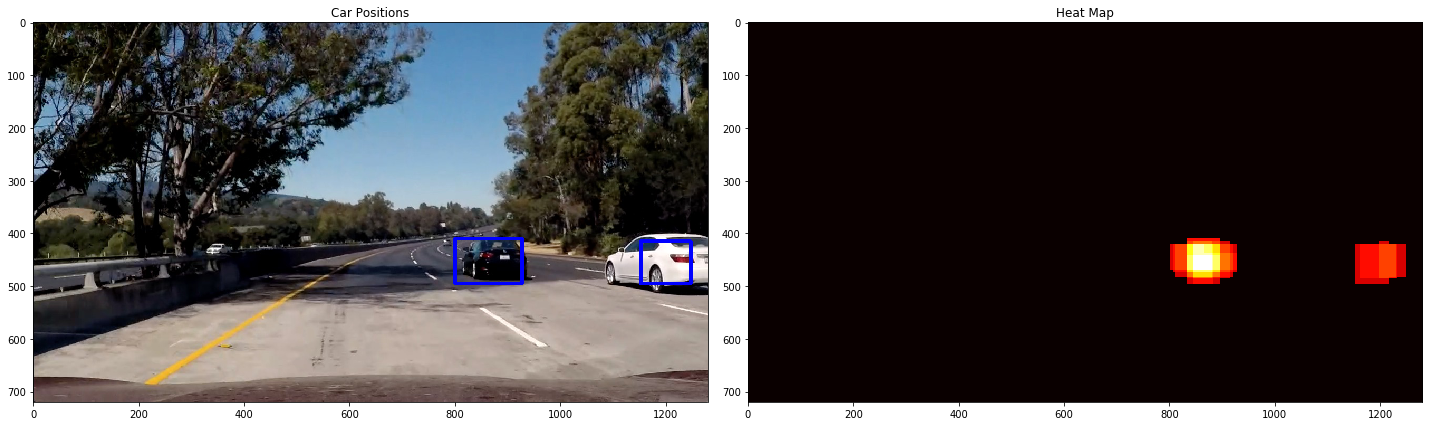

In [28]:
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heat, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Combine all the above functions to process one frame

In [34]:
def process_img(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 405
    ystop = 510
    scale = 1.0
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 410
    ystop = 510
    scale = 1.0
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 420
    ystop = 484
    scale = 1.0
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 415
    ystop = 500
    scale = 1.1
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 420
    ystop = 498
    scale = 1.2
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 420
    ystop = 564
    scale = 1.5
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 400
    ystop = 628
    scale = 2.0
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 420
    ystop = 612
    scale = 3.0
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 410
    ystop = 634
    scale = 3.5
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heat = np.zeros_like(img[:,:,0])
    heat = add_heat(heat, rectangles)
    heat = apply_threshold(heat, 3)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

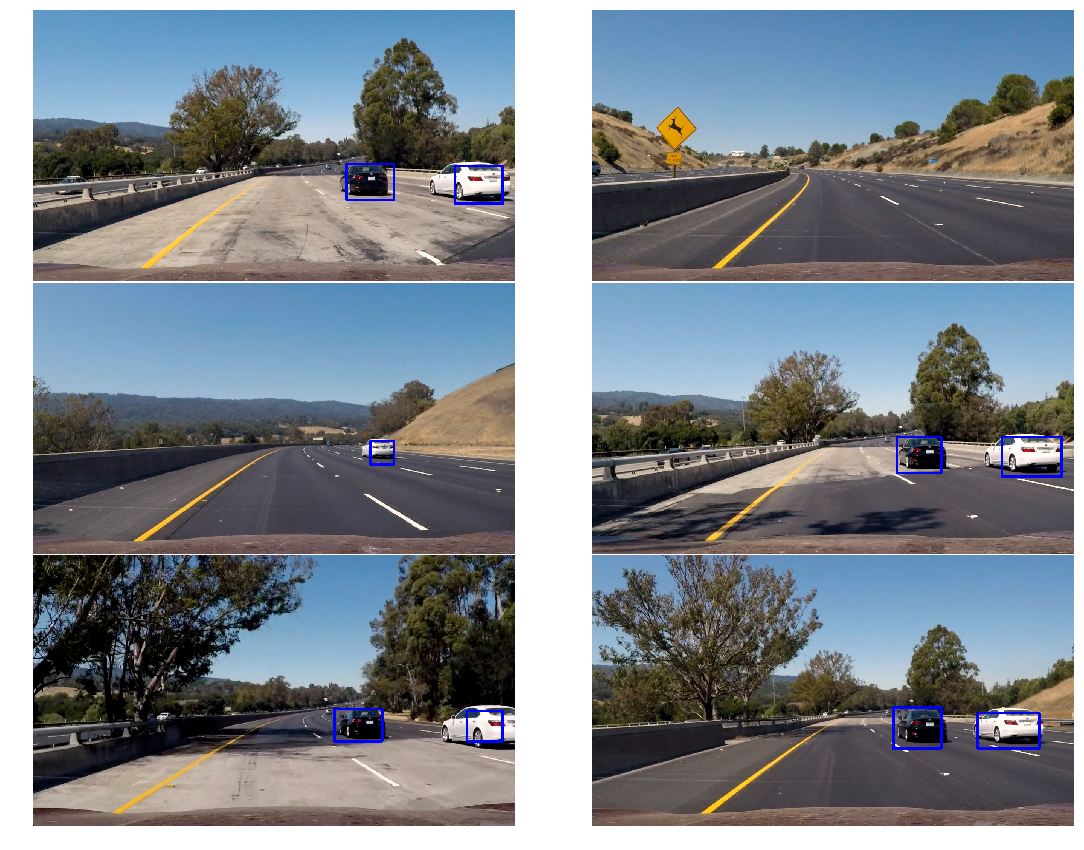

In [35]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axis = plt.subplots(3, 2, figsize=(20,15))
fig.subplots_adjust(hspace = .004, wspace=.002)
axis = axis.ravel()

for i, im in enumerate(test_images):
    axis[i].imshow(process_img(mpimg.imread(im)))
    axis[i].axis('off')

## Process video with the pipeline

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = 'test_video_out_1.mp4'

## Use the both lines for a shorter subclip, use only the first line for entire video
clip1 = VideoFileClip("test_video.mp4")
#clip1 = clip1.subclip(37,43)
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
white_output = 'project_video_out_1.mp4'

## Use the both lines for a shorter subclip, use only the first line for entire video
clip = VideoFileClip("project_video.mp4")
#clip1 = clip1.subclip(37,43)
white_clip = clip.fl_image(process_img)
%time white_clip.write_videofile(white_output, audio=False)

In [37]:
class HeatHistory():
    def __init__(self):
        self.history = []

In [38]:
# a more advanced function
def process_img_adv(img):

    rectangles = []

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 405
    ystop = 510
    scale = 1.0
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 410
    ystop = 510
    scale = 1.0
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 420
    ystop = 484
    scale = 1.0
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 415
    ystop = 500
    scale = 1.1
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 420
    ystop = 498
    scale = 1.2
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 420
    ystop = 564
    scale = 1.5
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 400
    ystop = 628
    scale = 2.0
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 420
    ystop = 612
    scale = 3.0
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    ystart = 410
    ystop = 634
    scale = 3.5
    out_img,rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rects=False)
    rectangles.append(rects)

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # consider history frames for detection
    #history = HeatHistory()
    
    heat = np.zeros_like(img[:,:,0])
    heat = add_heat(heat, rectangles)
    
    if len(history.history) >= 7:
        history.history = history.history[1:]
    
    history.history.append(heat)
    heat_history = reduce(lambda h, acc: h + acc, history.history)/7
    
    heat = apply_threshold(heat_history, 2.7)
     
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [39]:
history = HeatHistory()

white_output = 'project_video_out_his7thresh27new.mp4'

## Use the both lines for a shorter subclip, use only the first line for entire video
clip1 = VideoFileClip("project_video.mp4")
#clip1 = clip1.subclip(37,43)
white_clip = clip1.fl_image(process_img_adv) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out_his7thresh27new.mp4
[MoviePy] Writing video project_video_out_his7thresh27new.mp4


100%|█████████████████████████████████████▉| 1260/1261 [14:56<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_his7thresh27new.mp4 

Wall time: 14min 56s
